
Задание 2:

По каждому из классов (business, entertainment, politics, sport, tech) вам необходимо взять каждый класс и смоделировать распределение топиков (тем) по каждому из классов и построить визуализации. Необходимо объяснить о чем больше всего говорится в каждом из классов, то есть сделать на основании вашей работы анализ по каждому из классов. Используем любой подход, который вам известен для задачи Topic Modelling. 

### Импортируем библиотеки 

In [1]:
# Отключаем параллелизм в библиотеке Hugging Face tokenizers, чтобы избежать ошибок при использовании многопоточности.
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings
import torch
from collections import Counter
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import chardet
from transformers import pipeline
import nltk 
import networkx as nx


# Отключаем предупреждения
warnings.filterwarnings('ignore')

# Загрузка ресурсов NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Загрузка и предобработка данных.

In [2]:
# Класс для загрузки и предобработки данных
class DataLoader:
    def __init__(self, data_dir="bbc/"):
        self.data_dir = data_dir
        self.documents = []
        self.labels = []
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.load_data()

    def detect_encoding(self, file_path):
        """Определяет кодировку файла."""
        with open(file_path, 'rb') as f:
            raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']

    def load_data(self):
        """Загружает документы из директории."""
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                file_path = os.path.join(root, file)
                try:
                    encoding = self.detect_encoding(file_path)
                    with open(file_path, 'r', encoding=encoding) as f:
                        text = f.read().strip()
                        self.documents.append(text)
                        self.labels.append(os.path.basename(root))
                except Exception as e:
                    print(f"Ошибка при чтении {file}: {e}")
        
        self.df = pd.DataFrame({
            'text': self.documents,
            'label': self.labels
        })

    def preprocess_text(self, text):
        """Предобработка текста."""
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens # Лемматизация
                 if token not in self.stop_words and len(token) > 2] # Удаление стоп-слов
        return ' '.join(tokens)

    def prepare_data(self, texts):
        """Подготовка данных для моделирования."""
        processed_texts = [self.preprocess_text(text) for text in texts]
        count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
        tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
        count_matrix = count_vectorizer.fit_transform(processed_texts)
        tfidf_matrix = tfidf_vectorizer.fit_transform(processed_texts)
        return processed_texts, count_vectorizer, tfidf_vectorizer, count_matrix, tfidf_matrix

### Моделирование LDA, LSA

In [3]:
# Класс для тематического моделирования
class TopicModeler:
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def train_lda(self, count_matrix, count_vectorizer, n_topics=5):
        """Обучение LDA."""
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda_output = lda.fit_transform(count_matrix)
        feature_names = count_vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10-1:-1]]
            top_weights = [topic[i] for i in topic.argsort()[:-10-1:-1]]
            topics.append((top_words, top_weights))
    
        # Вычисление когерентности
        dictionary = Dictionary([text.split() for text in self.data_loader.df['text'].tolist()])
        coherence_model_lda = CoherenceModel(
            topics=[top[0] for top in topics],
            texts=[text.split() for text in self.data_loader.df['text'].tolist()],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_lda = coherence_model_lda.get_coherence()
        print(f"LDA Coherence Score: {coherence_lda:.4f}")
        
        # Вычисление перплексии
        perplexity = lda.perplexity(count_matrix)
        print(f"LDA Perplexity: {perplexity:.4f}")
        
        return lda, topics

    def train_lsa(self, tfidf_matrix, tfidf_vectorizer, n_topics=5):
        """Обучение LSA."""
        lsa = TruncatedSVD(n_components=n_topics, random_state=42)
        lsa_output = lsa.fit_transform(tfidf_matrix)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        topics = []
        for topic_idx, topic in enumerate(lsa.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10-1:-1]]
            top_weights = [topic[i] for i in topic.argsort()[:-10-1:-1]]
            topics.append((top_words, top_weights))
    
        # Вычисление когерентности
        dictionary = Dictionary([text.split() for text in self.data_loader.df['text'].tolist()])
        coherence_model_lsa = CoherenceModel(
            topics=[top[0] for top in topics],
            texts=[text.split() for text in self.data_loader.df['text'].tolist()],
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_lsa = coherence_model_lsa.get_coherence()
        print(f"LSA Coherence Score: {coherence_lsa:.4f}")
    
        return lsa, lsa_output, topics


### Моделирование BERT

In [4]:
# Класс для кластеризации с использованием BERT
class BertClusterer:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)

    def train_clustering(self, texts, n_clusters=5):
        """Кластеризация с использованием BERT."""
        embeddings = self.model.encode(texts, show_progress_bar=True)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings)

        # Вычисление метрик
        silhouette_avg = silhouette_score(embeddings, clusters)
        print(f"BERT Clustering Silhouette Score: {silhouette_avg:.4f}")
        
        calinski_harabasz = calinski_harabasz_score(embeddings, clusters)
        print(f"BERT Clustering Calinski-Harabasz Index: {calinski_harabasz:.4f}")
        
        return clusters, embeddings

## Визуализации

In [5]:
# Класс для визуализации
class Visualizer:
    def visualize_word_weights(self, topics, title="Word Weights"):
        """Визуализация весов слов."""
        plt.figure(figsize=(15, 10))
        for idx, (words, weights) in enumerate(topics):
            plt.subplot(2, 3, idx + 1)
            plt.barh(words, weights, color='skyblue')
            plt.title(f"Topic {idx + 1}")
            plt.xlabel("Weight")
            plt.ylabel("Words")
        plt.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()

    def visualize_tsne(self, embeddings, labels, title="t-SNE Visualization", perplexity=30):
        """Визуализация t-SNE."""
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        tsne_results = tsne.fit_transform(embeddings)
        
        unique_labels = list(set(labels))
        label_to_num = {label: i for i, label in enumerate(unique_labels)}
        numeric_labels = [label_to_num[label] for label in labels]
        
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=numeric_labels, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, ticks=range(len(unique_labels)), label='Category')
        plt.title(title)
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()

    def visualize_cosine_similarity(self, cosine_sim_matrix, title="Cosine Similarity"):
        """Визуализация матрицы косинусного сходства."""
        plt.figure(figsize=(10, 8))
        sns.heatmap(cosine_sim_matrix, cmap="YlOrRd", annot=False, fmt=".2f", vmin=0, vmax=1)
        plt.title(title)
        plt.xlabel("Документы")
        plt.ylabel("Документы")
        plt.show()

### Суммаризация

In [6]:
# Класс для суммаризации текста
class TextSummarizer:
    def __init__(self, model_name="facebook/bart-large-cnn"):
        self.extractive_summarizer = self.summarize_text_extractive
        self.generative_summarizer = pipeline("summarization", model=model_name)

    def summarize_text_extractive(self, text, n_sentences=5):
        """Экстрактивная суммаризация текста с использованием TextRank."""
        sentences = sent_tokenize(text)
        if len(sentences) <= n_sentences:
            return text
         # Вычисляем TF-IDF для каждого предложения
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)
        similarity_matrix = cosine_similarity(tfidf_matrix)
        nx_graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(nx_graph)
        # Выбираем топ-n предложений
        ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
        selected_sentences = [s for _, s in ranked_sentences[:n_sentences]]
        
        return ' '.join(selected_sentences)
        
    # Формируем суммаризацию
    def summarize_text(self, text, max_length=130, min_length=30):
        """Комбинированная суммаризация: экстрактивная + генеративная."""
        extractive_summary = self.summarize_text_extractive(text)
        generative_summary = self.generative_summarizer(extractive_summary, max_length=max_length, min_length=min_length, do_sample=False)
        
        return generative_summary[0]['summary_text']

### Основной класс для анализа

In [7]:
# Основной класс для анализа
class NewsTopicModeling:
    def __init__(self, data_dir="bbc/"):
        self.data_loader = DataLoader(data_dir)
        self.topic_modeler = TopicModeler(self.data_loader)
        self.bert_clusterer = BertClusterer()
        self.visualizer = Visualizer()
        self.summarizer = TextSummarizer()

    def run_full_analysis(self, n_topics=5, n_clusters=5):
        """Запуск полного анализа."""
        categories = self.data_loader.df['label'].unique()
        for category in categories:
            self.analyze_category(category, n_topics, n_clusters)

    def analyze_category(self, category, n_topics=5, n_clusters=5):
        """Анализ для одной категории."""
        print(f"\n{'='*50}\nАнализ категории: {category}\n{'='*50}")
        
        category_texts = self.data_loader.df[self.data_loader.df['label'] == category]['text'].tolist()
        processed_texts, count_vectorizer, tfidf_vectorizer, count_matrix, tfidf_matrix = self.data_loader.prepare_data(category_texts)
        
        # LDA
        lda_model, lda_topics = self.topic_modeler.train_lda(count_matrix, count_vectorizer, n_topics)
        self.visualizer.visualize_word_weights(lda_topics, title=f"LDA Word Weights для {category}")
        
        # LSA
        lsa_model, lsa_output, lsa_topics = self.topic_modeler.train_lsa(tfidf_matrix, tfidf_vectorizer, n_topics)
        self.visualizer.visualize_word_weights(lsa_topics, title=f"LSA Word Weights для {category}")
        
        # BERT Clustering
        clusters, embeddings = self.bert_clusterer.train_clustering(category_texts, n_clusters)
        self.visualizer.visualize_tsne(embeddings, clusters, title=f"BERT Clustering t-SNE для {category}")

        # Суммаризация
        print(f"\nСуммаризация для категории {category}:")
        combined_text = ' '.join(category_texts)  # Объединяем все тексты категории
        summary = self.summarizer.summarize_text(combined_text, max_length=150, min_length=50)
        print(textwrap.fill(summary, width=80))  # Вывод суммаризации с переносом строк
       



### Вывод результатов

Device set to use cuda:0



Анализ категории: sport
LDA Coherence Score: 0.4080
LDA Perplexity: 1941.6320


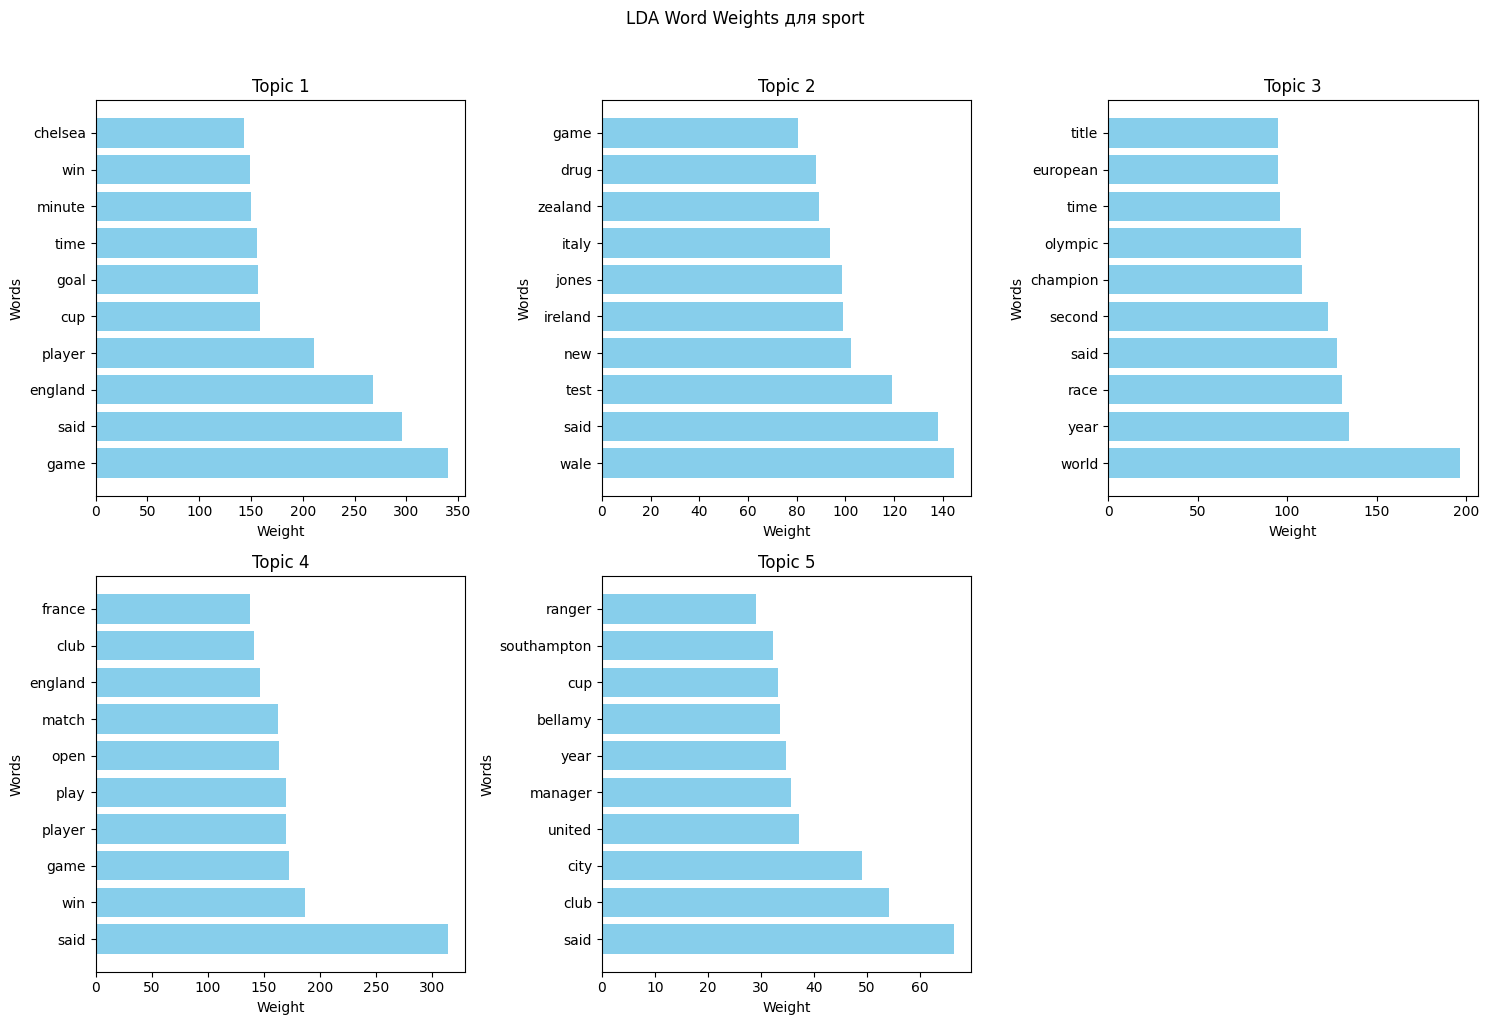

LSA Coherence Score: 0.5417


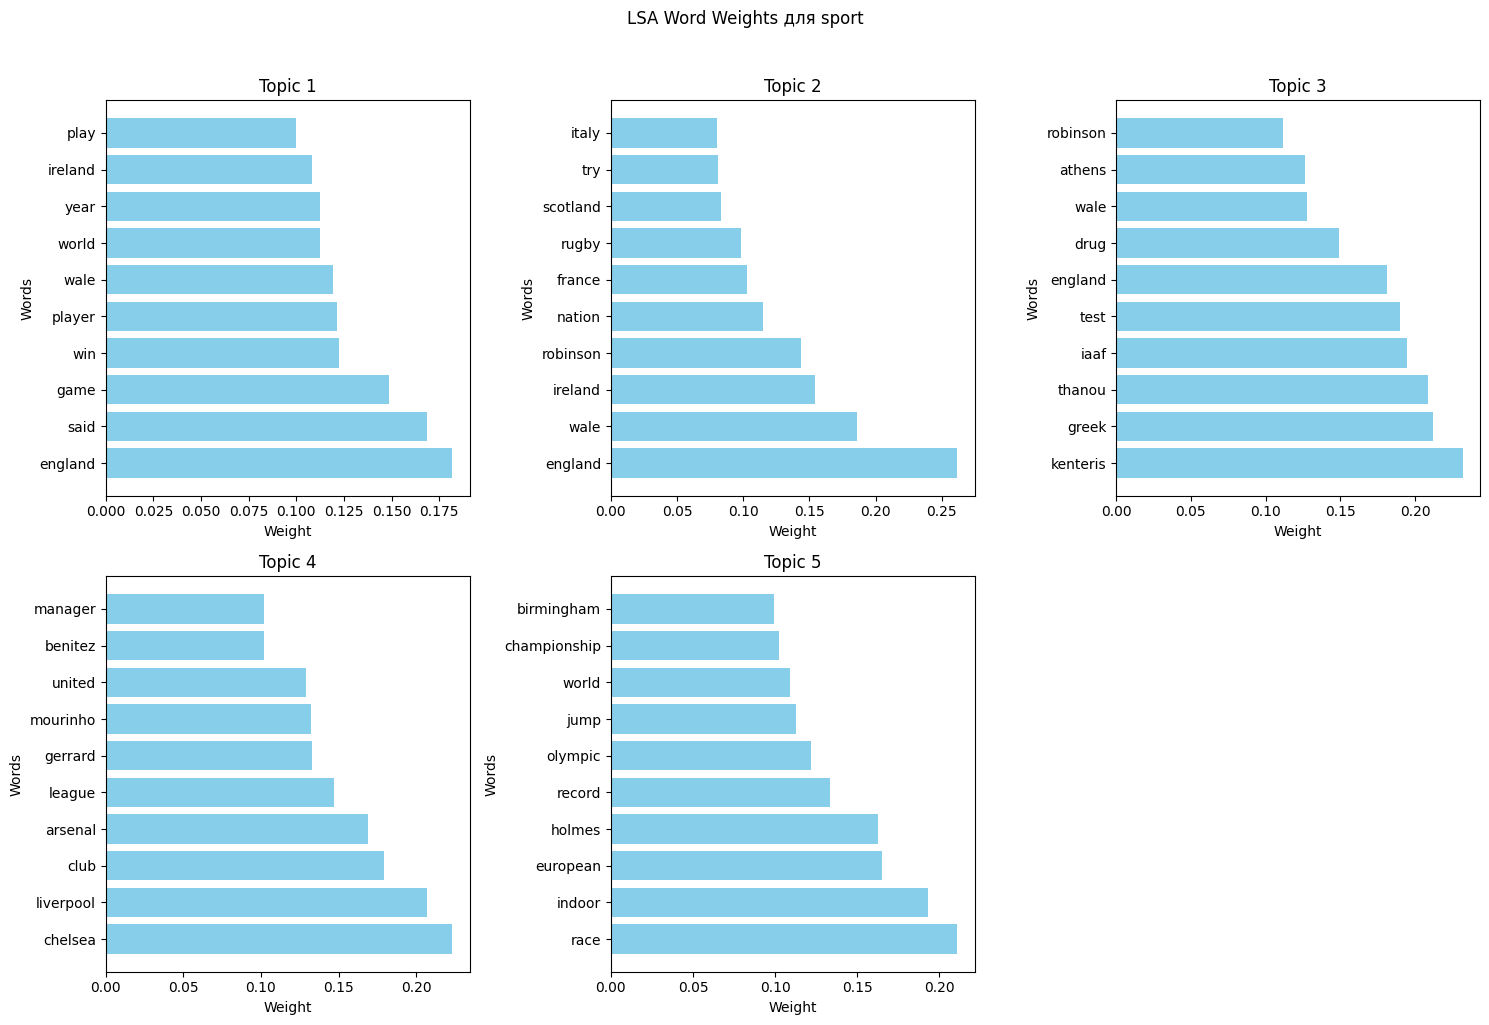

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

BERT Clustering Silhouette Score: 0.0729
BERT Clustering Calinski-Harabasz Index: 28.8316


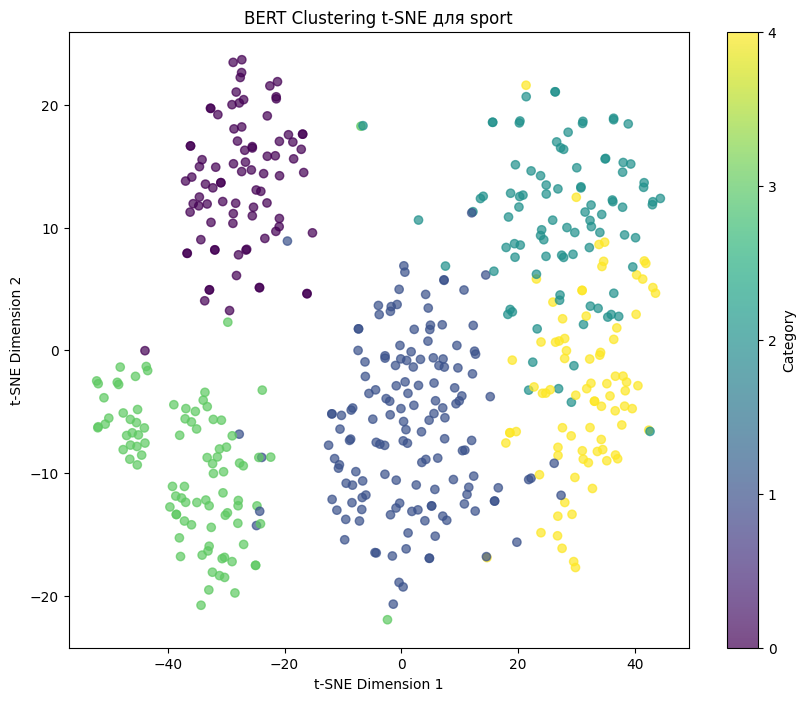


Суммаризация для категории sport:
"We are upset now, but the referee is in charge and he has called it his way and
we have got to be able to cope with that," he said. "At the minute, we are at
the top of the league and still in with a chance of staying in Europe, so I
don't think it is the crisis people have been trying to make out," he added.

Анализ категории: entertainment
LDA Coherence Score: 0.4884
LDA Perplexity: 2229.9901


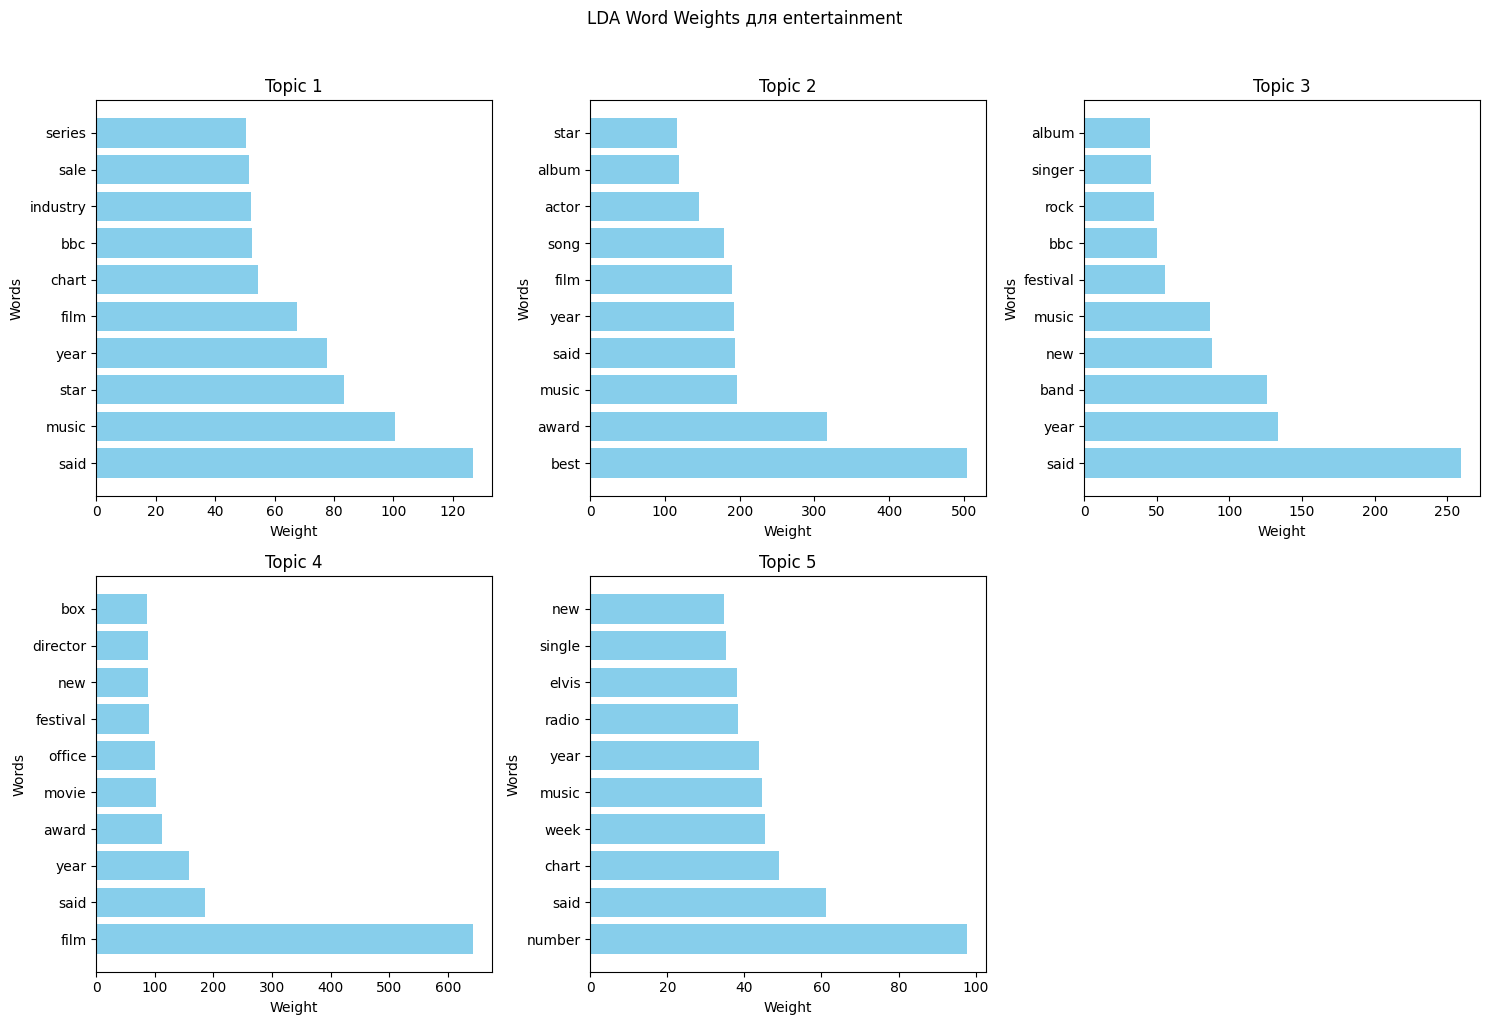

LSA Coherence Score: 0.6195


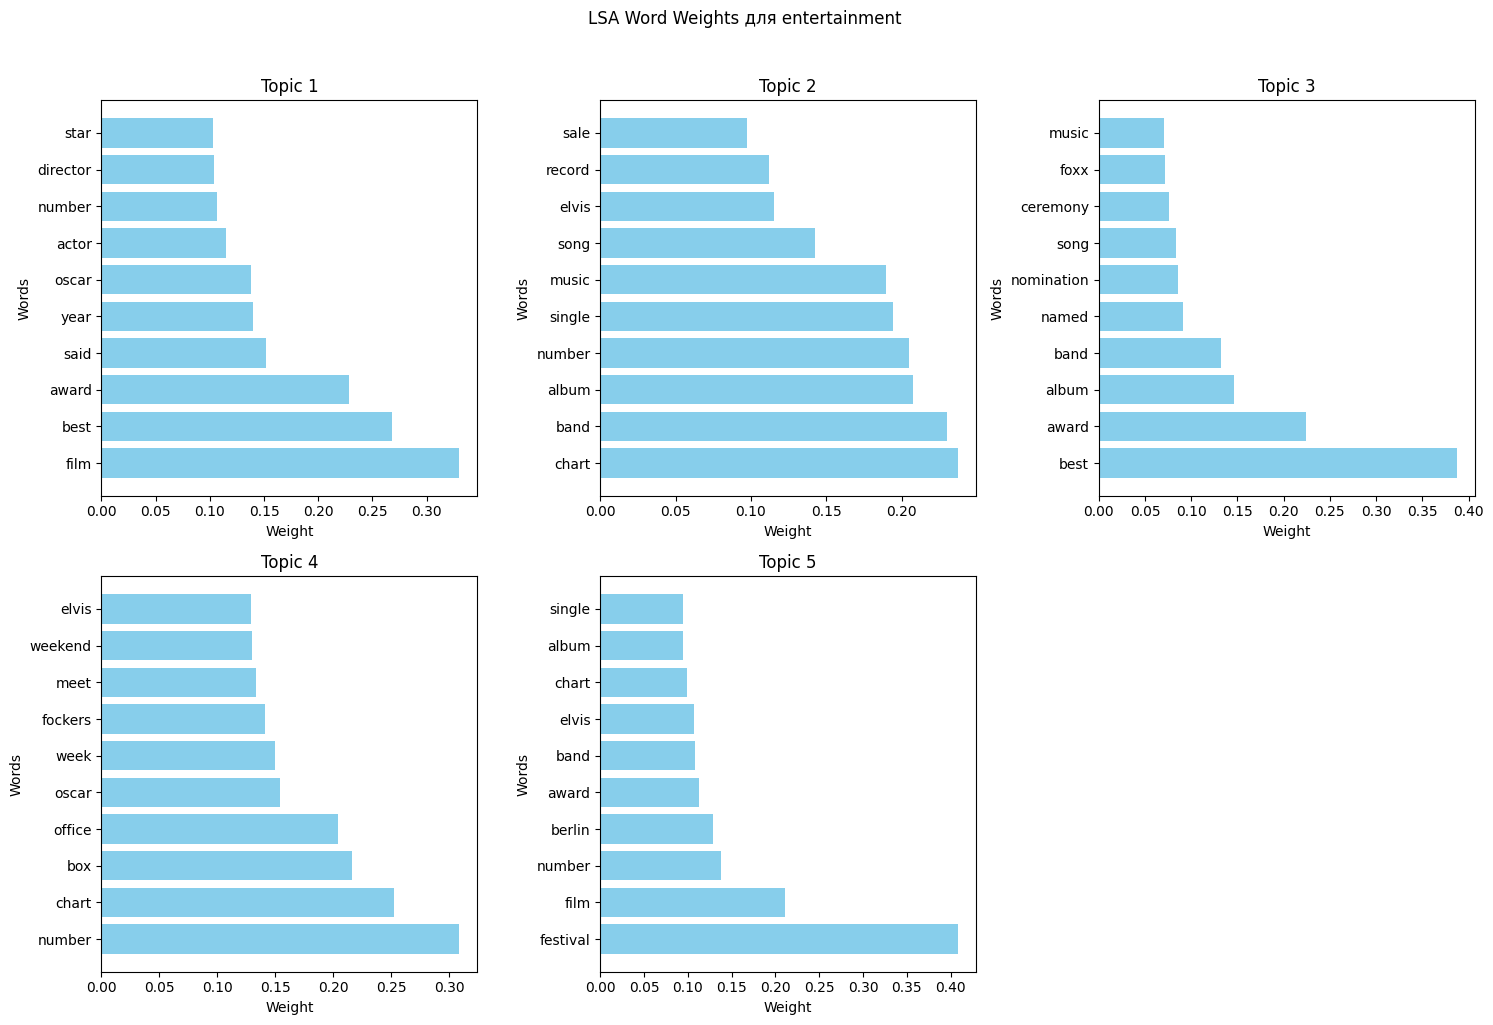

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

BERT Clustering Silhouette Score: 0.0495
BERT Clustering Calinski-Harabasz Index: 14.8694


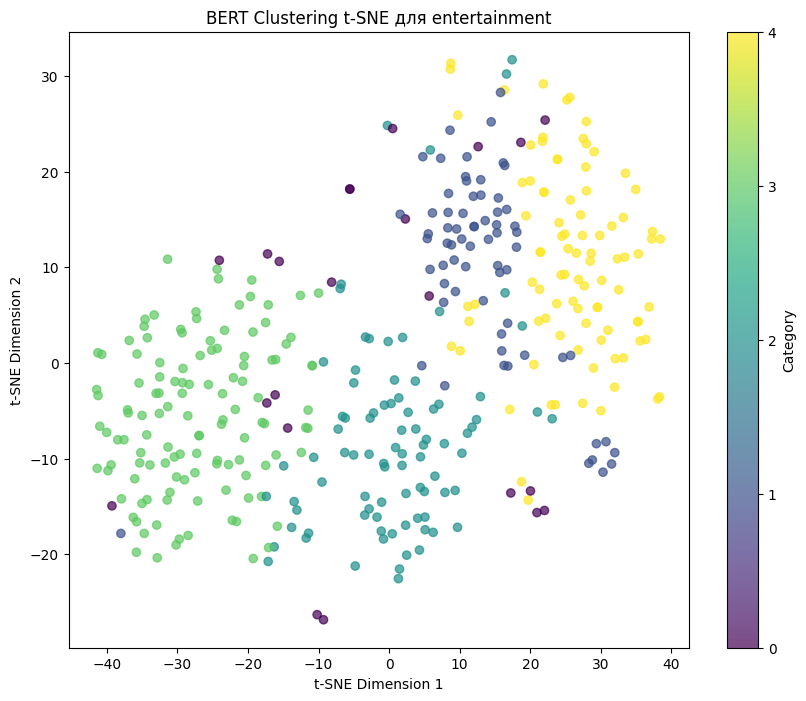


Суммаризация для категории entertainment:
The original stage production of The Sound of Music is to be performed for the
first time in the Austrian capital. The move is the biggest shake-up in the
history of the show, which was first broadcast in 1964. The Super Bowl is
watched by an audience of 144.4 million in the US.

Анализ категории: politics
LDA Coherence Score: 0.3693
LDA Perplexity: 1800.6821


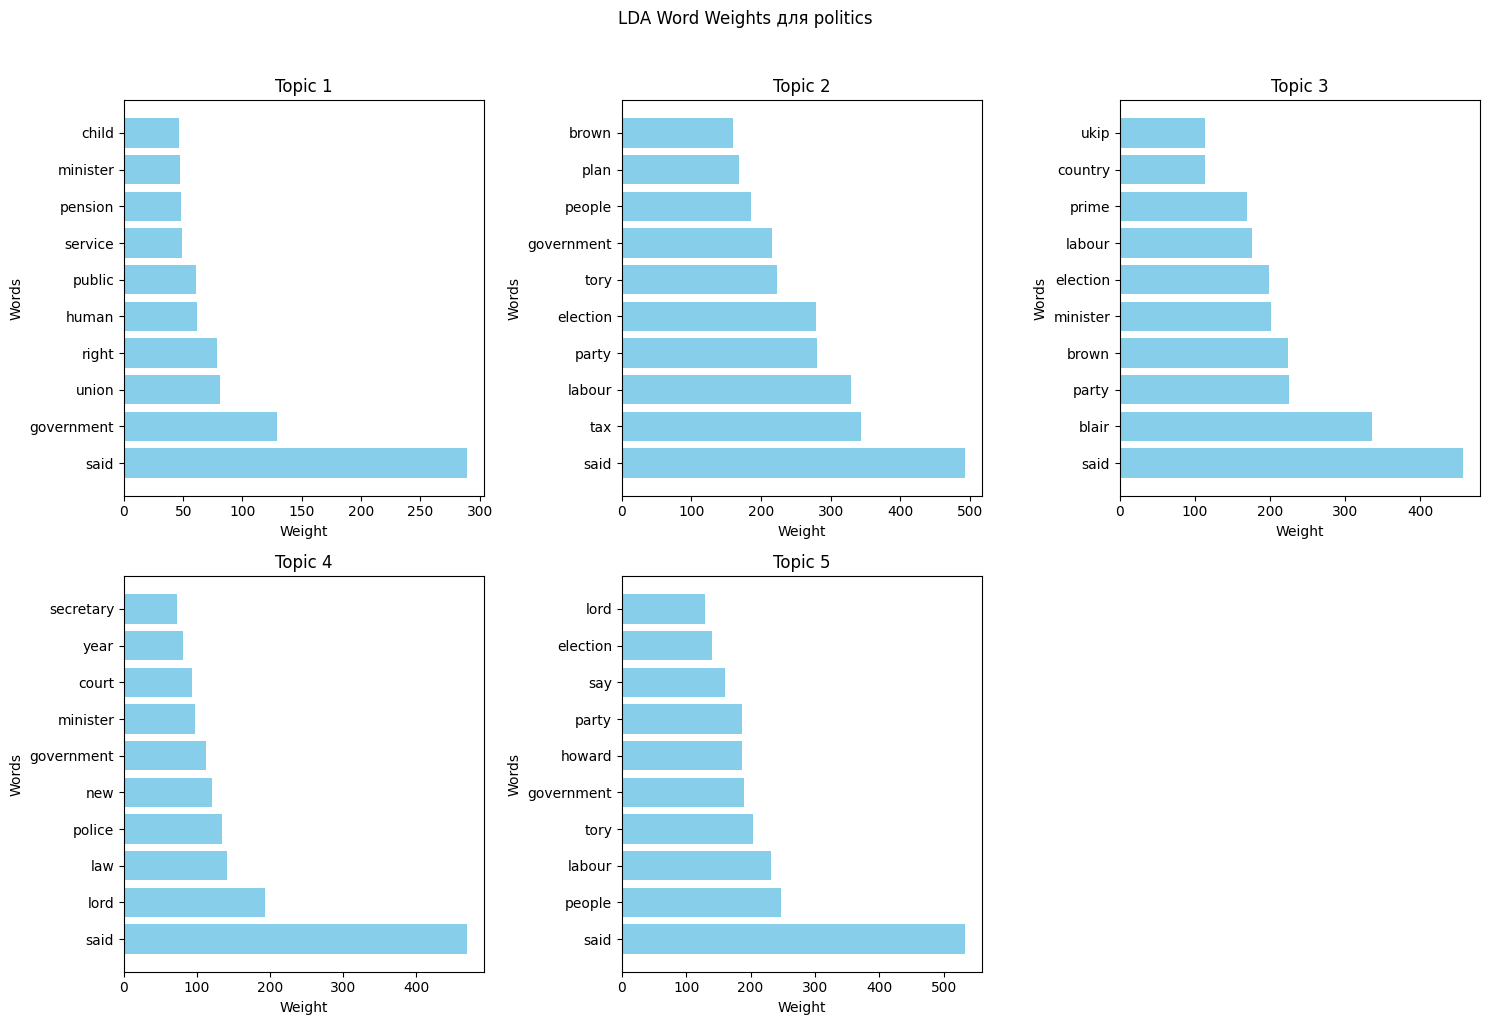

LSA Coherence Score: 0.5282


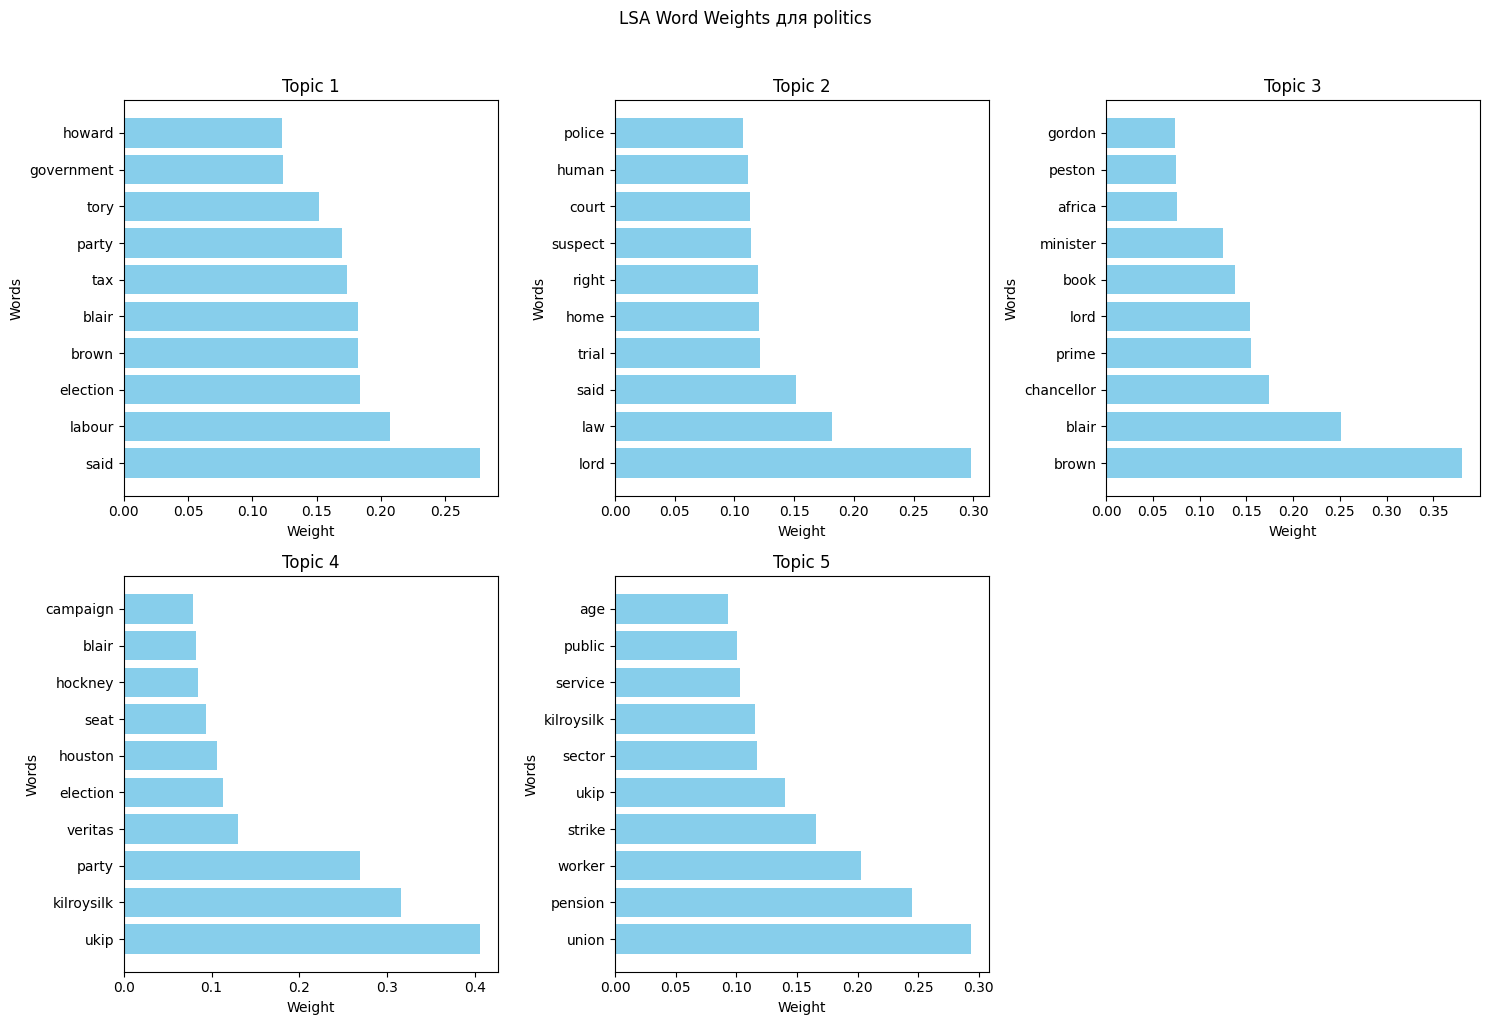

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

BERT Clustering Silhouette Score: 0.0274
BERT Clustering Calinski-Harabasz Index: 12.4738


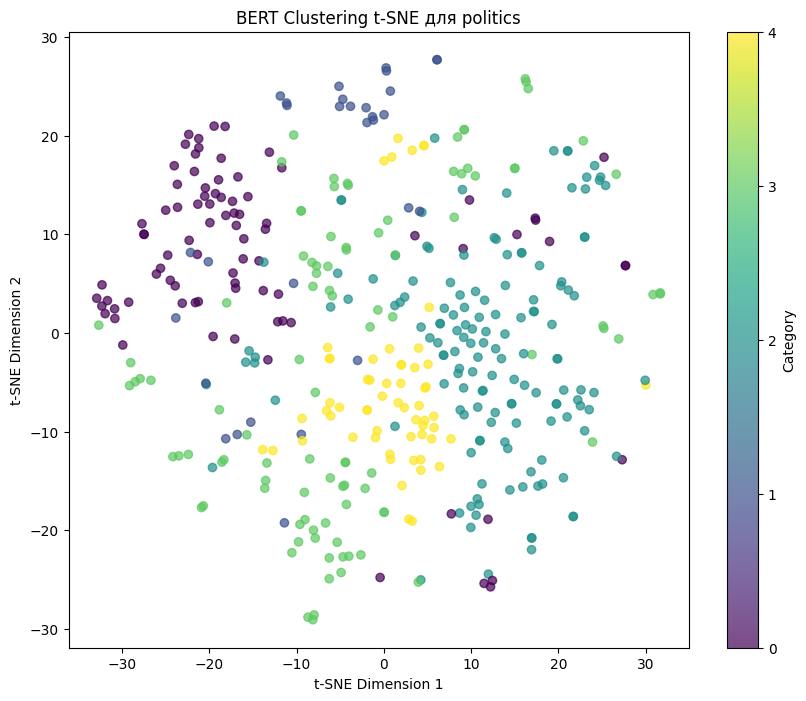


Суммаризация для категории politics:
Tories believe Tony Blair is using the issue to suggest the Tories are soft on
terrorism. Mr Brown's Budget was not about what was good for the country, but
"all about the interests of the Labour party," the Tory leader said. It is the
latest in a series of events designed to show the prime minister is speaking
directly to voters.

Анализ категории: business
LDA Coherence Score: 0.5625
LDA Perplexity: 1854.0019


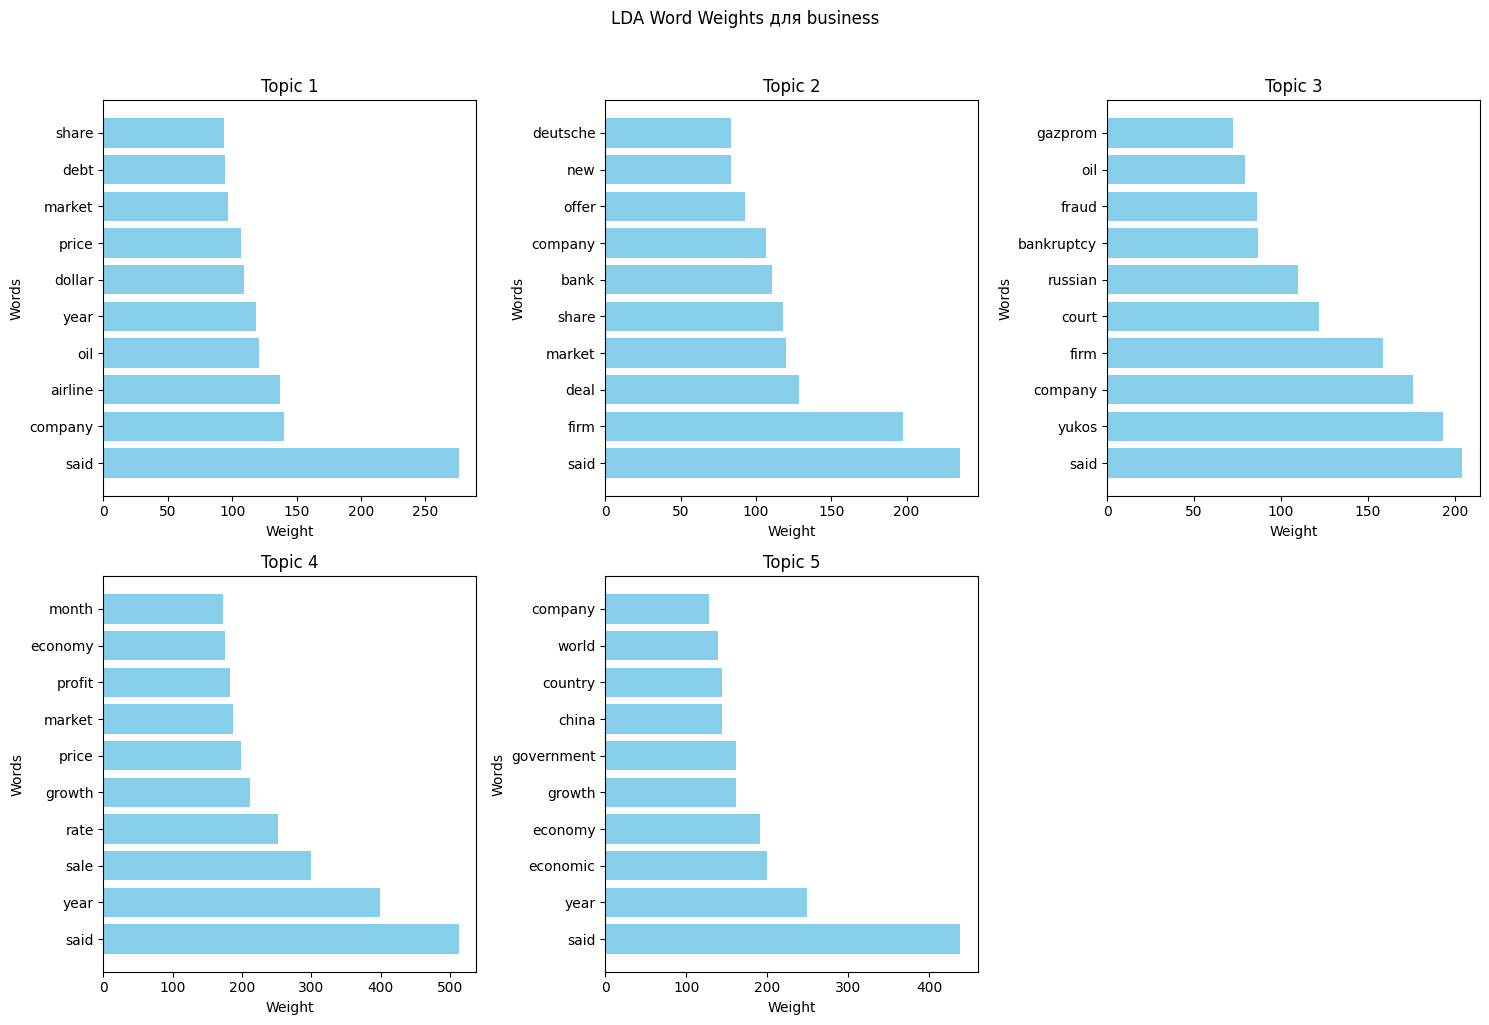

LSA Coherence Score: 0.6449


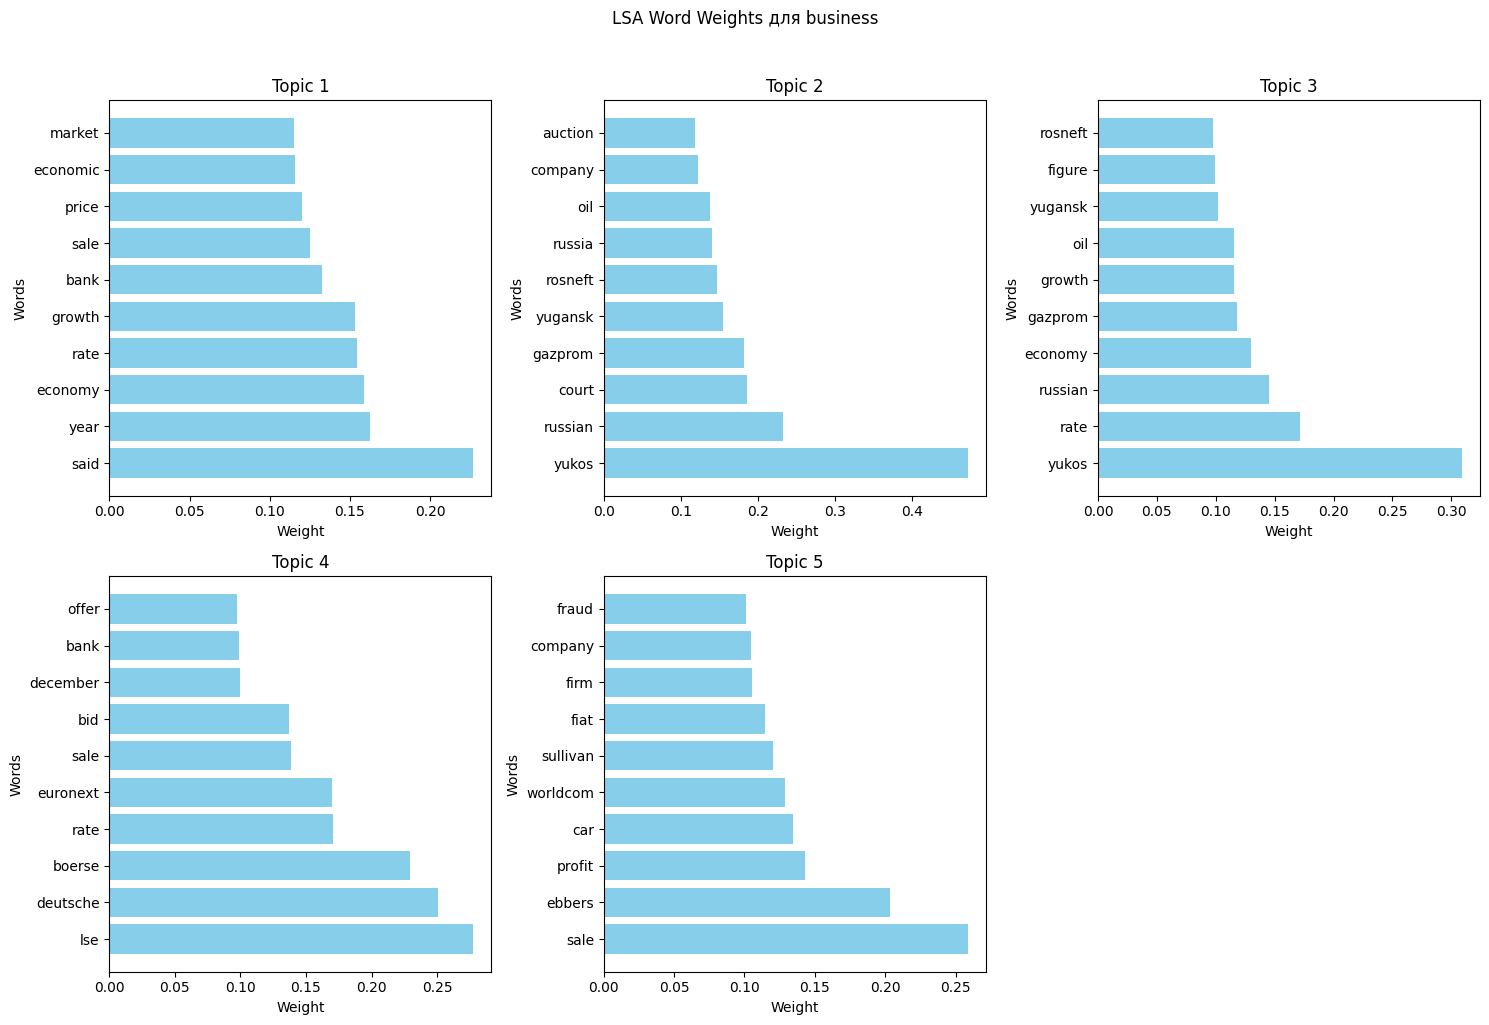

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

BERT Clustering Silhouette Score: 0.0393
BERT Clustering Calinski-Harabasz Index: 17.6893


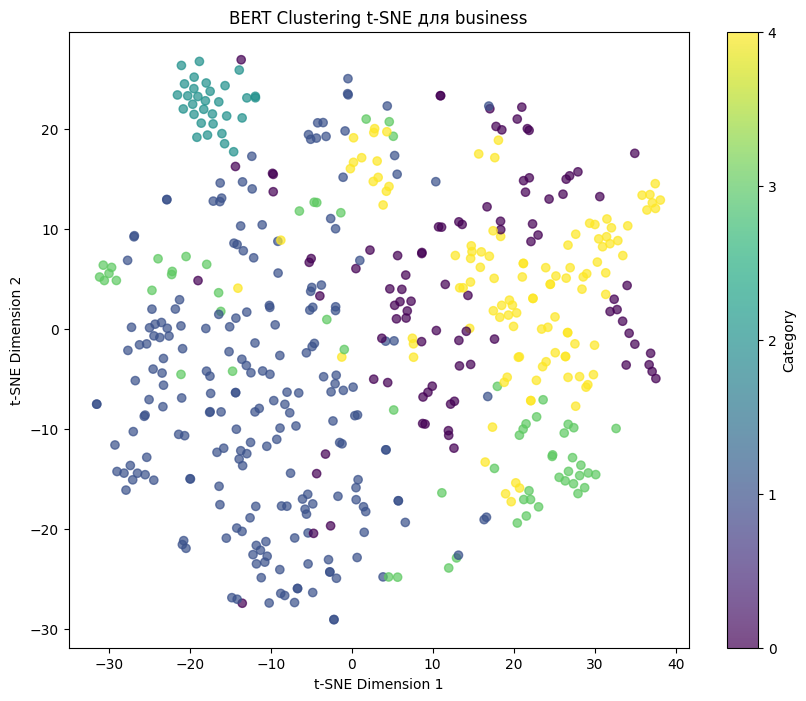


Суммаризация для категории business:
Growth was at an annual rate of 4% in the third quarter of 2004. For the year it
came in at 4.4%, the best figure in five years. Sales were down more than 25%
from the previous year to 1.4bn rupees.

Анализ категории: tech
LDA Coherence Score: 0.4511
LDA Perplexity: 1783.0278


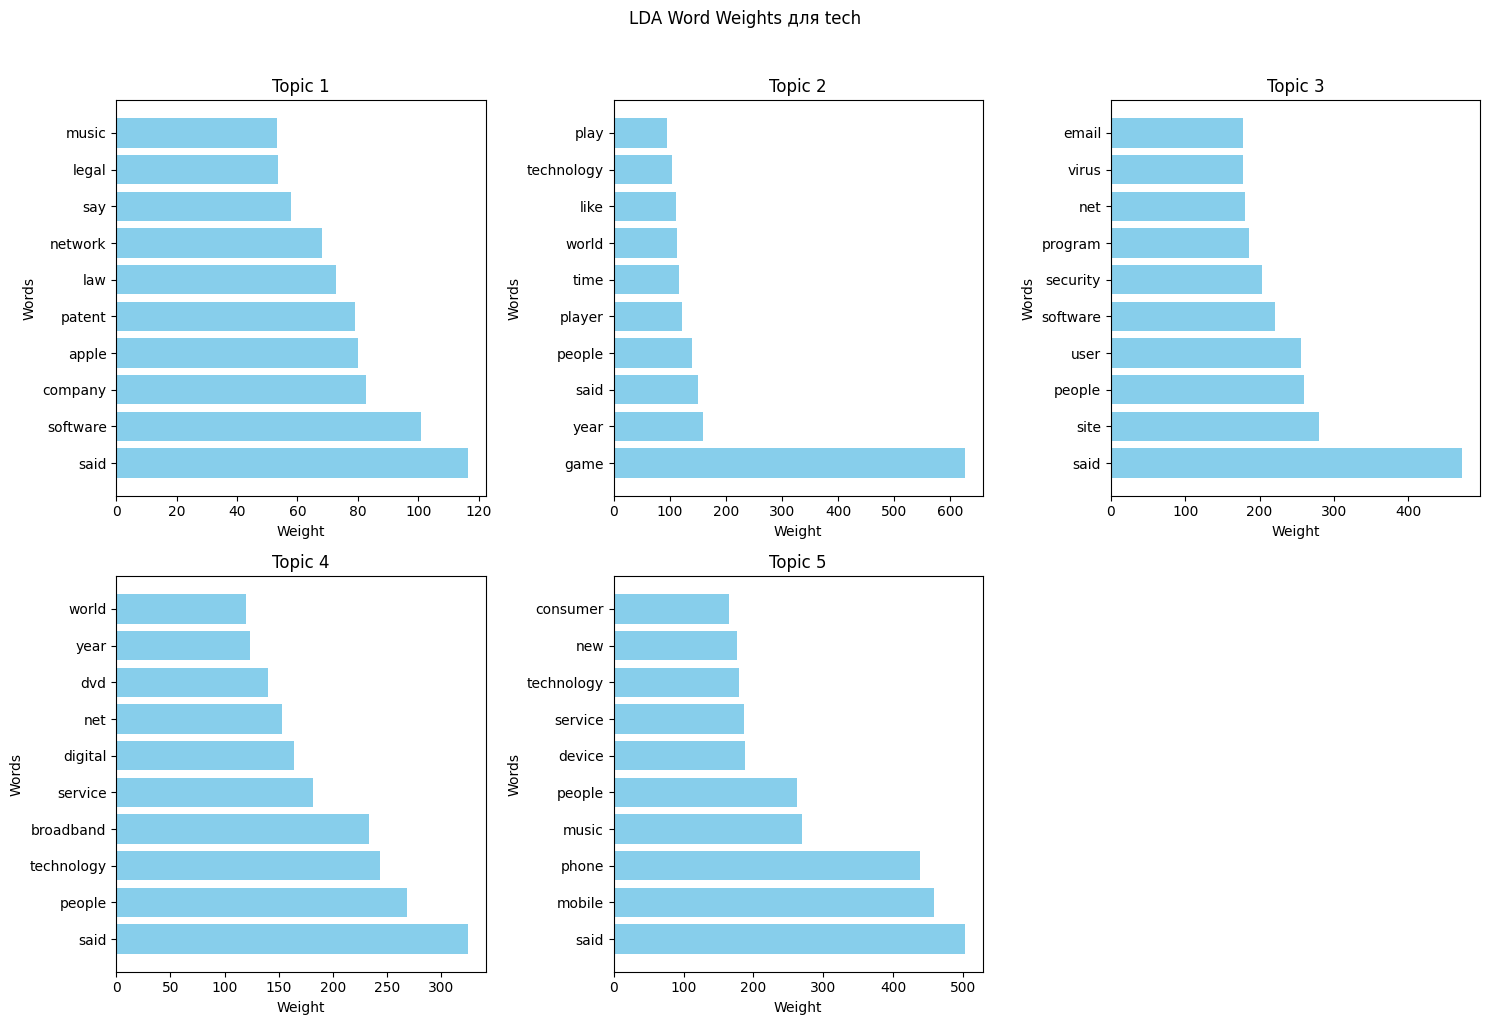

LSA Coherence Score: 0.4725


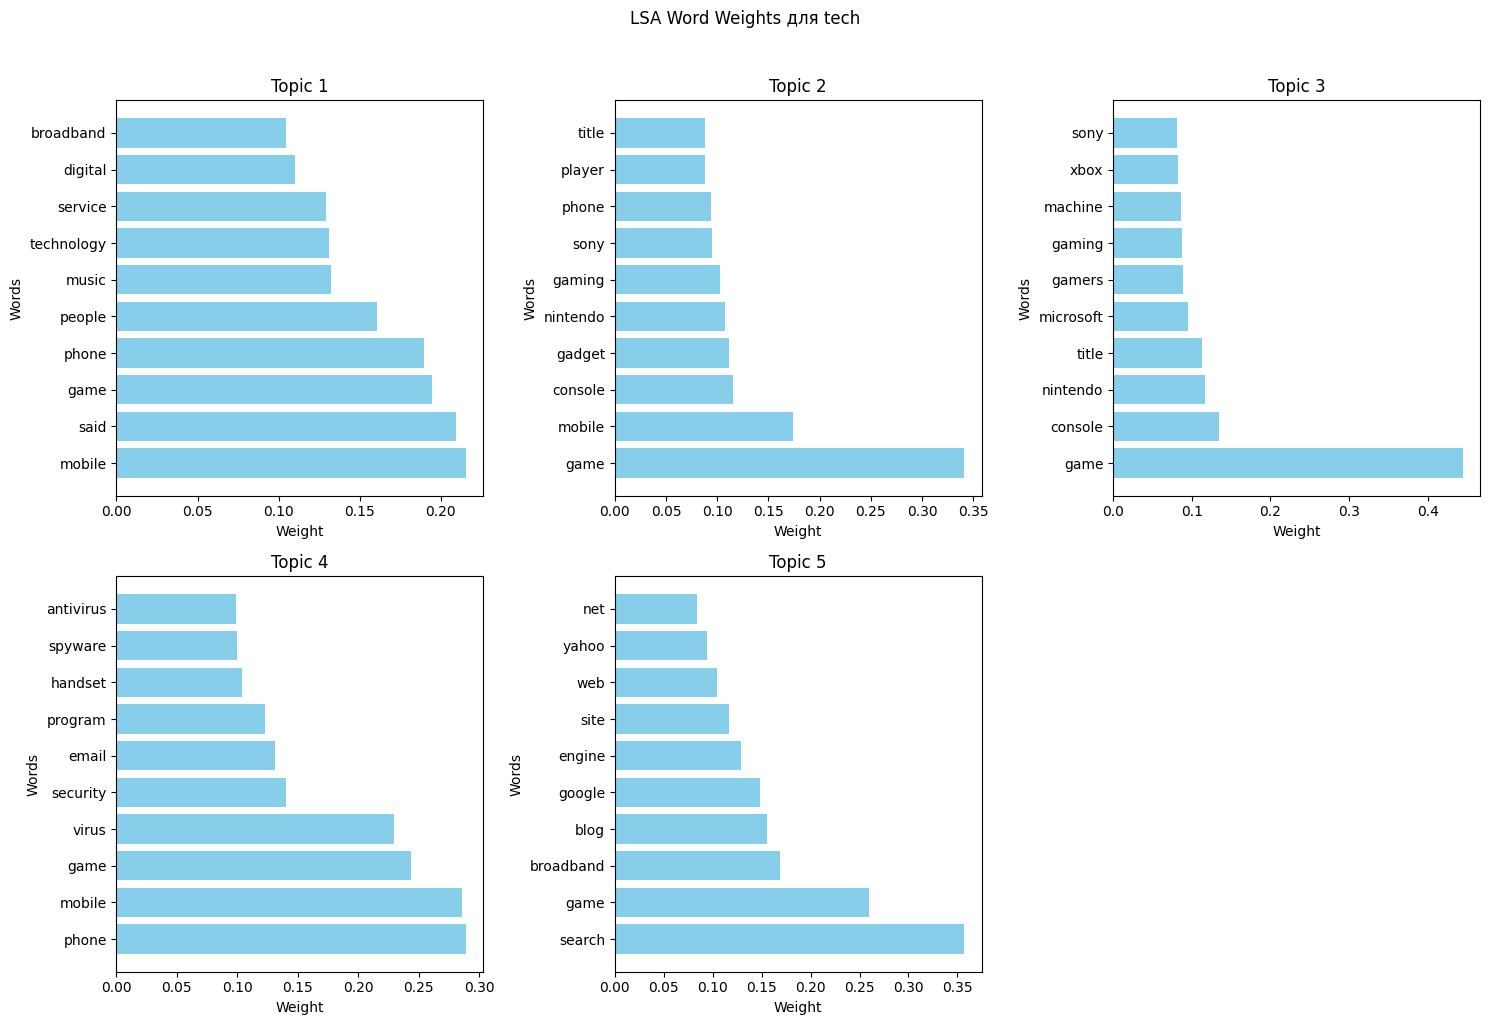

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

BERT Clustering Silhouette Score: 0.0586
BERT Clustering Calinski-Harabasz Index: 16.5037


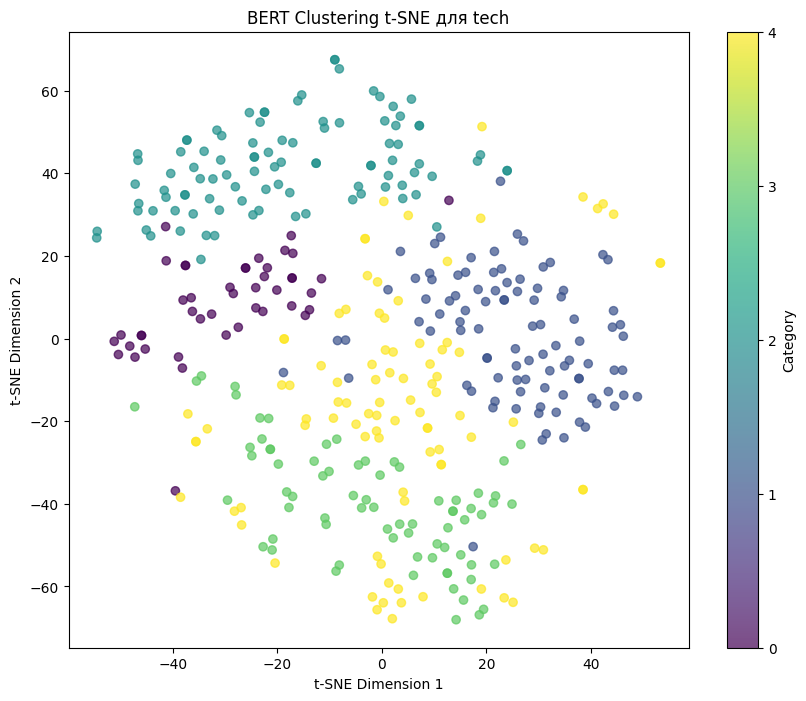


Суммаризация для категории tech:
The Porsche radio is set to go on sale at the end of January in the US and in
the first quarter of 2005 in the UK. He said the products which will be making
waves in the next year will be about the "democratisation" of content.


In [8]:
# Запуск анализа
if __name__ == "__main__":
    topic_modeling = NewsTopicModeling("bbc/")
    topic_modeling.run_full_analysis(n_topics=5, n_clusters=5)

### Выводы 

1. Категория sport:
  
    - LDA vs LSA:
    LSA показала лучшую интерпретируемость тем по сравнению с LDA (Coherence Score: 0.5417 против 0.4080). Это говорит о том, что LSA лучше справляется с выделением семантически связанных тем для ваших данных.
    LDA имеет высокую перплексию (1941.6320), что указывает на плохую предсказательную способность модели.
  
   - Кластеризация BERT
     Кластеризация на основе BERT показала низкое качество (Silhouette Score: 0.0729, Calinski-Harabasz Index: 28.8316).
     Результат указывает на то, что кластеры плохо разделены, и модель не смогла выделить четкие группы текстов. 

   -  Суммаризация:
     Суммаризация успешно выделила ключевые темы, связанные с решениями судей и положением команд в лиге, что полезно для быстрого понимания основных аспектов текстов.

2. Категория entertaunment
   - LDA 
     Coherence Score: 0.4884
     Оценка: Значение близкое к 0.5 считается приемлемым, что может указывать на то, что темы, выявленные LDA, не полностью связаны между собой, и можно рассмотреть возможность настройки параметров модели или предварительной обработки данных.
     Perplexity: 2229.9901
     Оценка: Чем ниже значение perplexity, тем лучше модель. Однако, perplexity не всегда является надежным показателем, особенно в сочетании с coherence score.
     
   - LSA 
     Coherence Score: 0.6195
     Оценка: Значение Coherence Score для LSA выше, чем для LDA, что является положительным знаком. Оно указывает на то, что темы, выявленные с помощью LSA, более связаны и логичны. Это может означать, что LSA лучше подходит для этой категории новостей.
     
   -  Кластеризация BERT
    Silhouette Score: 0.0495
    Оценка: Значение silhouette score близкое к 0 указывает на то, что кластеры плохо отделены друг от друга. Идеальное значение находится в диапазоне от -1 до 1, где значения близкие к 1 означают хорошую кластеризацию. Это значение говорит о том, что кластеры могут пересекаться, и возможно стоит рассмотреть улучшение параметров кластеризации или использование других методов.
    Calinski-Harabasz Index: 14.8694
    Оценка: Значение Calinski-Harabasz Index также указывает на качество кластеризации. Более высокие значения указывают на более четкие и разделенные кластеры, но в данном случае значение также невысокое. Это подтверждает, что кластеры могут быть не очень хорошо отделены.
    -  Суммаризация
    Суммаризация для категории "entertainment" выглядит информативно и предоставляет ключевые моменты из новостей. Она демонстрирует, что основные события связаны с культурными мероприятиями и популярными событиями, такими как "The Sound of Music" и "Super Bowl". Это указывает на то, что модель хорошо справляется с извлечением значимых фактов.

3. Категория "politics"
   - LDA 
    Coherence Score: 0.3693
    Оценка: Значение Coherence Score значительно ниже 0.5, что указывает на слабую связность тем, выявленных моделью LDA. Это  свидетельствует о том, что темы не являются достаточно четкими или что данные могут требовать дополнительной предварительной обработки. 
    Perplexity: 1800.6821
    Оценка: Хотя значение perplexity ниже, чем в предыдущем примере, оно все еще указывает на проблемы с моделью. Более низкие значения обычно указывают на лучшую модель, но в сочетании с низким coherence score это может означать, что модель не адекватно захватывает структуру данных.

   - LSA 
    Coherence Score: 0.5282
    Оценка: Это значение является более приемлемым и указывает на то, что темы, выявленные LSA, более связаны и логичны по сравнению с LDA. Тем не менее, оно все еще ниже 0.6, что также свидетельствует о том, что можно улучшить модель.

   - Кластеризация BERT
    Silhouette Score: 0.0274
    Оценка: Значение silhouette score близкое к 0 указывает на плохую отделенность кластеров. Это говорит о том, что кластеры могут пересекаться, и модель может быть неэффективной в разделении данных. 
    Calinski-Harabasz Index: 12.4738
    Оценка: Это значение также невысокое и указывает на то, что кластеры могут быть не очень четкими.

   - Суммаризация
    Суммаризация для категории "politics" предоставляет ключевые моменты из новостей. Она отражает текущие политические события и мнения.

4. Категория "business"
   - LDA 
    Coherence Score: 0.5625
    Оценка: Значение близко к 0.6 и указывает на приемлемую связность тем, выявленных моделью LDA. 
    Perplexity: 1854.0019
    Оценка: Значение perplexity относительно высокое, однако в сочетании со значением coherence score  модель требует доработки.

   - LSA 
    Coherence Score: 0.6449
    Оценка: Значение выше 0.6, что является положительным знаком. Оно указывает на то, что темы, выявленные с помощью LSA, более связаны и логичны, чем в случае LDA. Это означает, что LSA лучше подходит для анализа данных в категории "business".
   
   - Кластеризация BERT
    Silhouette Score: 0.0393
    Оценка: Значение silhouette score близкое к 0 указывает на плохую отделенность кластеров. Это говорит о том, что кластеры могут пересекаться, и модель может быть неэффективной в разделении данных. 
    Calinski-Harabasz Index: 17.6893
    Оценка: Это значение выше, чем в предыдущих примерах, что указывает на некоторое улучшение в качестве кластеризации. Однако оно все еще относительно низкое, и стоит рассмотреть возможность оптимизации метода кластеризации для достижения лучших результатов.

   - Суммаризация
    Суммаризация для категории "business" выглядит информативной и предоставляет ключевые данные о росте и продажах.

5. Категория "tech"
    -  LDA 
     Coherence Score: 0.4511
     Оценка: Значение ниже 0.5 указывает на слабую связность тем, выявленных моделью LDA. Темы могут быть нечеткими или недостаточно четкими, что говорит о необходимости улучшения модели. 
     Perplexity: 1783.0278
     Оценка: Хотя это значение немного ниже, чем в категории "business", оно все еще высокое. Высокая perplexity может указывать на то, что модель не адекватно захватывает структуру данных. 

   - LSA 
     Coherence Score: 0.4725
     Оценка: Это значение также ниже 0.5 и указывает на то, что темы, выявленные с помощью LSA, не являются достаточно связными. Хотя LSA может быть полезен, в данном случае он не показывает значительного преимущества по сравнению с LDA. 

   - Кластеризация BERT
     Silhouette Score: 0.0586
     Оценка: Значение silhouette score близкое к 0 указывает на плохую отделенность кластеров. Это говорит о том, что кластеры могут пересекаться, и модель может быть неэффективной в разделении данных. 
    Calinski-Harabasz Index: 16.5037
    Оценка: Это значение также низкое и указывает на то, что кластеры могут быть не очень четкими. 

   - Суммаризация
    Суммаризация для категории "tech" информативна и охватывает ключевые события, такие как запуск радиоприемника Porsche и тенденции в области контента. 